In [1]:
!pip install torchsummary
!pip install tqdm
!pip install torch
!pip install scikit-image
!pip install sklearn
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# importing the libraries
from torchsummary import summary
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
import random
from skimage.color import rgb2gray

In [3]:
#loaded images into data array. Image is read with skimage.io imread (newer reader).
#Image is divided by 255 to scale from 0-1
#data array is then converted to numpy array for further data augmentation

import cv2
import os
import glob
img_dir = "face_images/*"
files = glob.glob(img_dir)
data = []

for f1 in files:
    #imread stores image in rgb so no need to convert from bgr
    img = imread(f1)
    img = img/255
    data.append(img)

train_x = np.array(data)
train_x.shape

(675, 128, 128, 3)

In [4]:
# train_x, val_x= train_test_split(train_x, test_size = 0.1, random_state = 13)
# (train_x.shape), (val_x.shape)

In [5]:
#https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [6]:
#https://github.com/xkumiyu/numpy-data-augmentation/blob/master/process_image.py

import argparse
import os

import numpy as np
from PIL import Image
import cv2
from scipy.ndimage.interpolation import rotate

def read_image(imagefile, dtype=np.float32):
    image = np.array(Image.open(imagefile), dtype=dtype)
    return image


def check_size(size):
    if type(size) == int:
        size = (size, size)
    if type(size) != tuple:
        raise TypeError('size is int or tuple')
    return size


def subtract(image):
    image = image / 255
    return image


def resize(image, size):
    size = check_size(size)
    image = cv2.resize(src=image,dsize=size)
    return image


def center_crop(image, crop_size):
    crop_size = check_size(crop_size)
    h, w, _ = image.shape
    top = (h - crop_size[0]) // 2
    left = (w - crop_size[1]) // 2
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    image = image[top:bottom, left:right, :]
    return image


def random_crop(image, crop_size):
    crop_size = check_size(crop_size)
    h, w, _ = image.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    image = image[top:bottom, left:right, :]
    return image


def horizontal_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[:, ::-1, :]
    return image


def vertical_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[::-1, :, :]
    return image


def scale_augmentation(image, scale_range, crop_size):
    scale_size = np.random.randint(*scale_range)
    image = cv2.resize(src=image, dsize=(scale_size, scale_size))
    image = random_crop(image, crop_size)
    return image


def random_rotation(image, angle_range=(0, 180)):
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
    image = resize(image, (h, w))
    return image

In [7]:
import random
final_train_data = []
final_target_train = []

for i in tqdm(range(train_x.shape[0])):
    
    #random cropping
    final_train_data.append(random_crop(resize(train_x[i], 150),128))
    final_train_data.append(random_crop(resize(train_x[i], 190),128))
    final_train_data.append(random_crop(resize(train_x[i], 140),128))
    final_train_data.append(random_crop(resize(train_x[i], 220),128))
    #scale augmentation
    final_train_data.append(scale_augmentation(train_x[i],(256,480),128))
    final_train_data.append(scale_augmentation(train_x[i],(156,256),128))
    final_train_data.append(scale_augmentation(train_x[i],(198,256),128))
    final_train_data.append(scale_augmentation(train_x[i],(198,220),128))
    #random rotation
    final_train_data.append(random_rotation(train_x[i]))
    #converting rgb to grey
    #final_train_data.append(rgb2gray(train_x[i]))
    
    #random color scaling              
    final_train_data.append(random.uniform(0.6,1.01)*train_x[i,:,:])
    #original
    final_train_data.append(train_x[i])
    
    
    #random brightness
    final_train_data.append(train_x[i]*(random.randint(60,101)/100))
    
    #rotation by 45
    final_train_data.append(resize(rotate(train_x[i], angle=45, mode = 'wrap'),128))
    #rotation by 65
    final_train_data.append(resize(rotate(train_x[i], angle=65, mode = 'wrap'),128))
    #rotation by 15
    final_train_data.append(resize(rotate(train_x[i], angle=15, mode = 'wrap'),128))
    #rotation by 160
    final_train_data.append(resize(rotate(train_x[i], angle=160, mode = 'wrap'),128))
    #rotation by 120
    final_train_data.append(resize(rotate(train_x[i], angle=120, mode = 'wrap'),128))
    
    
    #flipping horizontally
    final_train_data.append(np.fliplr(train_x[i]))
    #flipping vertically
    final_train_data.append(np.flipud(train_x[i]))
    
    #flipped both way
    final_train_data.append((np.fliplr((np.flipud(train_x[i])))))
    
    #random chance that more than one transformation happens to the image
    if(random.randint(1,101)/100 < 0.4):
        image = train_x[i]
        image = random_crop(resize(image, 128),64)
        image = random_rotation(train_x[i])
        image = scale_augmentation(train_x[i],(256,480),224)
        image = resize(image,128)
        final_train_data.append(image)
    
#     final_train_data.append(random_noise(train_x[i],var=0.2**2))
    

100%|██████████| 675/675 [00:35<00:00, 19.13it/s]


In [8]:
#check for image clipping 
count = 0
for i in range(len(final_train_data)):
    
    if(len(final_train_data[i]) != 128):
        print(len(final_train_data[i]))
        print("Index:", i)
    count += 1
    
print(count)


13757


In [9]:
from skimage import io, color

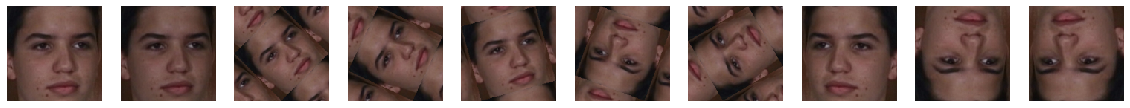

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=10,figsize=(20,20))
for i in range(10):
    ax[i].imshow(final_train_data[i+30])
    #x[i].imshow(final_train_data[i+30])
    ax[i].axis('off')

In [11]:
#import torch
#convert numpy image to tensor, converts rgb to lab profile
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

In [12]:
final_train_data_lab = final_train_data

In [13]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
#from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
num_epochs = 50 #number of epochs for training
batch_size = 512 #batch size for training
learning_rate = 1e-3
use_gpu = True

In [15]:
#https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/colorization.ipynb#scrollTo=j2MERVvtGYEy
#https://colab.research.google.com/drive/1r45y6bnxT1d8qUe5YDovWYUbfX1hMnAz#scrollTo=rRoQxRmuWqnG not using right now
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

cnet = ColorNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
cnet = cnet.to(device)

num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 773698


In [16]:
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

# dataset_lab_train = datasets.ImageFolder(data, transform = test_transform)
# data_set_train_tensor_lab = []
data_set_train_tensor_lab = []#torch.Tensor(final_train_data_lab) #CONVERTING LAB IMAGES TO TENSORS

#shuffles image array before converting to tensors in LAB format
np.random.shuffle(final_train_data_lab)

for img in final_train_data_lab:
    #import image converts all images from RGB to LAB
    data_set_train_tensor_lab.append(import_image(img))



In [17]:
test_transform = transforms.Compose([
        transforms.Lambda(import_image),
        #transforms.ToTensor()
    ])


# train_transforms = transforms.Compose([
#                                 transforms.RandomApply(torch.nn.ModuleList([
#                                 transforms.RandomRotation(30),
#                                 transforms.RandomResizedCrop(224),
#                                 transforms.RandomHorizontalFlip(),
#                                 #transforms.Grayscale(num_output_channels=1),
#                                 #transforms.Grayscale(num_output_channels=3),
                                
#                                 ]), p=0.3),
#                                 transforms.RandomGrayscale(p=0.1),
#                                 transforms.RandomRotation(30),
#                                 transforms.RandomVerticalFlip(p=0.5),
#                                 transforms.RandomResizedCrop(224),
#                                 transforms.RandomHorizontalFlip(),
#                                 #transforms.Lambda(color.rgb2lab),
#                                 #transforms.ToTensor(),
#                                 transforms.Normalize([0, 0, 0], [1, 1, 1]),
#                                 transforms.RandomApply(torch.nn.ModuleList([     
#                                     transforms.Normalize([0, 0, 0], [1, 1, 1]),
#                                     transforms.Normalize([0.5, 0.5, 0.5], [0.01, 0.01, 0.01]),
#                                     transforms.Normalize([0.8, 0.8, 0.8], [0.2, 0.2, 0.2]),
#                                 ])),
#                                 transforms.Lambda(import_image)
                           
# ])

In [18]:
from torchvision import datasets, transforms
test_dataset = datasets.ImageFolder("face_image_testset/", transform = test_transform)
# test_dataset = []
# for img in val_x:
#     test_dataset.append(import_image(img))



test_dataloader = torch.utils.data.DataLoader(test_dataset,            
                                          batch_size=1, 
                                          #GPU_data = True,
                                          pin_memory = True,
                                          num_workers=1,
                                         
                                         )

In [19]:
from torchvision import datasets, transforms
# dataset_notransform = datasets.ImageFolder("face_image_testset/", transform = test_transform)


# test_dataloader = torch.utils.data.DataLoader(dataset_notransform,            
#                                           batch_size=batch_size, 
#                                           #GPU_data = True,
#                                           pin_memory = True,
#                                           num_workers=1,
                                         
#                                          )






train_dataloader = torch.utils.data.DataLoader(data_set_train_tensor_lab,            
                                          batch_size=batch_size, 
                                          #GPU_data = True,
                                          pin_memory = True,
                                          num_workers=1,
                                         
                                         )

In [20]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch in train_dataloader:
        
        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 167.511804
Epoch [2 / 50] average reconstruction error: 148.013280
Epoch [3 / 50] average reconstruction error: 129.033308
Epoch [4 / 50] average reconstruction error: 108.814436
Epoch [5 / 50] average reconstruction error: 89.074122
Epoch [6 / 50] average reconstruction error: 71.296618
Epoch [7 / 50] average reconstruction error: 55.965245
Epoch [8 / 50] average reconstruction error: 43.647979
Epoch [9 / 50] average reconstruction error: 34.717674
Epoch [10 / 50] average reconstruction error: 28.377976
Epoch [11 / 50] average reconstruction error: 24.241981
Epoch [12 / 50] average reconstruction error: 21.590529
Epoch [13 / 50] average reconstruction error: 20.022690
Epoch [14 / 50] average reconstruction error: 18.931513
Epoch [15 / 50] average reconstruction error: 18.773076
Epoch [16 / 50] average reconstruction error: 17.708956
Epoch [17 / 50] average reconstruction error: 16.840935
Epoch [18 / 50] average reconstruction e

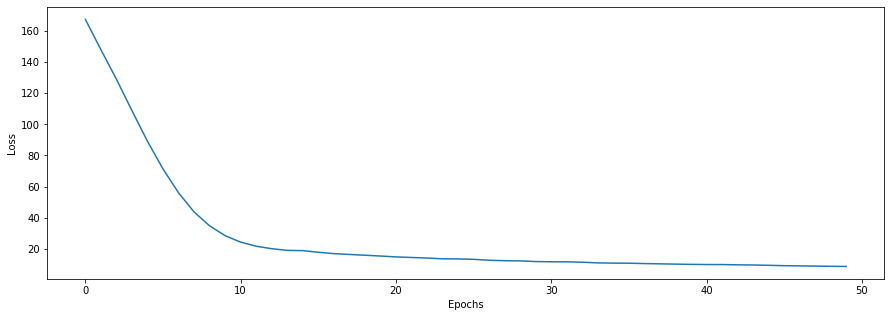

In [21]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
# set to evaluation mode
cnet.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in test_dataloader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))


#512 batch size 9.08 validation dataset was trained
#256 batch size 10.292643 validation dataset was trained
#256 batch size 13.67 validation dataset was not trained 
#256 batch size 14.29 validation dataset was not trained, added more augmentations 1 


#256 batch size 12.14 average loss, validation dataset was not trained. Added more augmentations 2 used 90% of 90% of data
#256 11.59 average loss, validation dataset was not trained. Same augmentation 2, used 90% 675 instead of 607
#256 26.23 average loss 

#128 24.21 loss
#512 batch size   13.048798  average loss, validation dataset was not trained. Same augmentation 2, used 90% 675 instead of 607
#512 batch size 17.999


#512 bath size shuffled data average loss 10.64 50 epochs lowest 7.19
#1024 10.31 average loss
#32 9.83 average loss
#256 10.506 average loss
#16 10.79                      100 epochs
#64 50 epochs 14.17 loss


#1024 average loss 11.06 Will use 1024 batch size 50 epochs

average loss: 11.068172


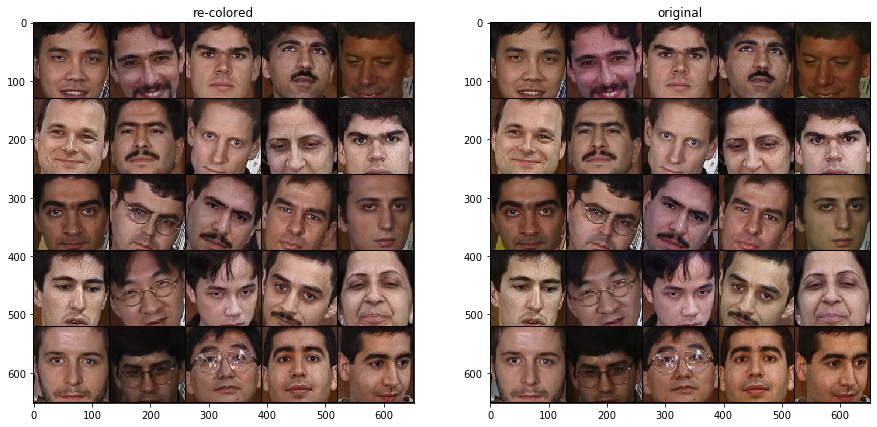

In [23]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()